In [45]:
from qcportal import PortalClient
from openff.toolkit.topology import Molecule
from chargecraft.storage.storage import MoleculePropStore
from sklearn.metrics import mean_squared_error
from rdkit import Chem
from rdkit.Chem import Draw

import pandas as pd
import seaborn as sns
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

Build a dataframe from the local qcarchive

In [ ]:
DATASET_NAME = ""

client = PortalClient(address="")

dataset = client.get_dataset(dataset_type="singlepoint", dataset_name=DATASET_NAME)

add_data = []
for spec in dataset.specification_names:
    for index, _, record in dataset.iterate_records(specification_names=spec, status="complete"):
        record_data = {
            "specification": spec,
            "molecule": index,
            "tagged_smiles":Molecule.from_qcschema(record.molecule).to_smiles(mapped = True),
            "basis": record.specification.basis,
            "method": record.specification.method,
            "conformer_geom" : Molecule.from_qcschema(record.molecule).conformers[0].m,
            "dipole": record.properties["scf dipole"],
            "charges": record.properties["mbis charges"],
            "mbis dipoles": record.properties["mbis dipoles"],
            "mbis quadrupoles": record.properties["mbis quadrupoles"],
            "wall time": record.provenance.wall_time
        }
        add_data.append(record_data)

df = pd.DataFrame(add_data)
df.to_csv("benchmark_data.csv")
df

Now, check if we can access the CCSD database using the chargecraft code. The list() method lists all the smiles present in the database.

In [47]:
# benchdb = MoleculePropStore('./database.db')
benchdb = MoleculePropStore('/Users/localadmin/ccsd_data.db')
benchdb.list()

['CC(C)F',
 '[O-]c1ccsn1',
 'Clc1cccnc1',
 'Brc1cc[nH]c1',
 'COCC(F)(F)F',
 'CCOB(O)O',
 'O=C1CCCN1',
 'Fc1ccccc1',
 'CC(=O)O',
 'COC',
 'CCO',
 'CC(C)=O',
 'CC(=O)[O-]',
 'Clc1ccccc1',
 'c1c[nH+]c[nH]1',
 'C1CCNC1',
 'CC',
 'CCSC',
 'CCS']

You can retrieve items by running .retrieve([smiles]) on the MoleculePropStore object. 

In [48]:
benchdb.retrieve('CC')

[MoleculePropRecord(tagged_smiles='[C:1]([C:2]([H:6])([H:7])[H:8])([H:3])([H:4])[H:5]', conformer=array([[-0.76121044,  0.01704435,  0.02132174],
        [ 0.76121109, -0.01704159, -0.02132468],
        [-1.16238031, -0.83813842,  0.56928049],
        [-1.12460595,  0.92247717,  0.51188822],
        [-1.18721113, -0.00656134, -0.98390396],
        [ 1.12458527, -0.92240799, -0.5120533 ],
        [ 1.16241327,  0.83822474, -0.5691178 ],
        [ 1.1871982 ,  0.00640308,  0.98390928]]), grid_coordinates=array([[-3.8890873 , -1.06066017, -0.70710678],
        [-3.8890873 , -1.06066017,  0.        ],
        [-3.8890873 , -1.06066017,  0.70710678],
        ...,
        [ 3.8890873 ,  1.06066017, -0.70710678],
        [ 3.8890873 ,  1.06066017,  0.        ],
        [ 3.8890873 ,  1.06066017,  0.70710678]]), esp=array([[-0.00139294],
        [-0.00151105],
        [-0.00120838],
        ...,
        [-0.00120818],
        [-0.00151079],
        [-0.00139278]]), electric_field=array([[ 5.57

Now lets combine the outputs of the CCSD database with the DFT calculations from our local qcarchive instance. 

In [ ]:
prop_store = benchdb
smiles_list = df['molecule'].unique()
add_data = []
for mol in smiles_list:
    print(mol)
    try:
        item =  prop_store.retrieve(smiles=mol,method='ccsd',basis='aug-cc-pvtz')
        record_data = {
                "specification": 'ccsd-aug-cc-pVTZP',
                "molecule": mol,
                "tagged_smiles":item[0].tagged_smiles,
                "basis": 'aug-cc-pVTZP',
                "conformer_geom": item[0].conformer,
                "dipole": item[0].dipole,
                "charges": item[0].mbis_charges.flatten(),
                "mbis dipoles": item[0].mbis_dipole.flatten(),
                "mbis quadrupoles": item[0].mbis_quadropole.flatten(),
                "esp": item[0].esp_quantity,
                "grid": item[0].grid_coordinates_quantity,
            }
        add_data.append(record_data)
    except IndexError:
        continue
df_ccsd = pd.DataFrame(add_data)

df = pd.concat([df,df_ccsd], axis=0)


Brc1ccccc1
Brc1cc[nH]c1
c1ccccc1
C1CCNC1
C1CC[NH2+]CC1
C1CCOC1
c1ccsc1
c1c[nH+]c[nH]1
CC
Cc1c[nH]c2ccccc12
CC(C)F
CC(C)=O
CCO
CCOB(O)O
CC(=O)[O-]
CC(=O)O
CCS
CCSC
Clc1ccccc1
Clc1cccnc1
COC
COC[B-](F)(F)F
COCC(F)(F)F
CO[Si](C)(C)O
C[Si]1(C)CCCC1
CS(=O)(=O)[O-]
Fc1ccccc1
Fc1cccc(F)c1F
Nc1ccccc1
N#Cc1ccccc1
Oc1ccccc1
O=C1CCCN1
[O-]c1ccsn1
[S-]c1ccccc1


In [ ]:
#build a pickle file of the databse for running later. 
if 'molecule' not in df.columns or 'conformer_geom' not in df.columns:
    raise ValueError("DataFrame must contain 'molecule' and 'conformer_geom' columns.")

df = df.dropna(subset=['molecule', 'conformer_geom'])

smiles_conformers_dict = {}

grouped = df.groupby('molecule')

for smiles, group in grouped:
    conformer_geoms = group['conformer_geom'].tolist()
    smiles_conformers_dict[smiles] = conformer_geoms

output_file = 'smiles_conformers.pkl'

with open(output_file, 'wb') as f:
    pickle.dump(smiles_conformers_dict, f)

print(f"Dictionary of SMILES and conformer geometries has been saved to '{output_file}'.")


Dictionary of SMILES and conformer geometries has been saved to 'smiles_conformers.pkl'.


In [23]:
# alternatively we can directly load the database associated with the csv to reproduce the figures directly here
# df = pd.read_csv('benchmark_data.csv', index_col=0)
# df
df = pd.read_pickle('benchmark_data.pkl')
df


,specification,molecule,basis,conformer_geom,dipole,charges,mbis dipoles,mbis quadrupoles,wall time,esp,grid
0,b3lyp-gas-6-311G*,c1ccccc1,6-311g*,"[[0.797450858, -1.13261916, 0.014782105], [1.3...","[-3.886498263216964e-07, 1.0286883478372033e-0...","[-0.13426860392723794, -0.13421192811843438, -...","[-0.01720053700385921, 0.02445345646623114, -0...","[-4.597649893819507, -0.07531917616986908, 0.0...",6.960770,NaN,NaN
1,b3lyp-gas-6-311G*,CC(=O)O,6-311g*,"[[-0.95521381, -0.09210192, 0.02388881], [0.48...","[-0.0948937395848759, -0.4347353235965983, 0.4...","[-0.6439346786505051, 0.8724046202580775, -0.6...","[-0.004950681591170853, -0.006333994248682766,...","[-5.408727723864018, -0.030558386203656696, 0....",5.870446,NaN,NaN
2,b3lyp-gas-6-311G*,CC1=CNc2c1cccc2,6-311g*,"[[0.782144471, -1.37434457, -0.0555852664], [2...","[-0.337956801940134, 0.7475064269689398, 0.020...","[-0.15120110640614065, -0.18638628152719913, -...","[-0.013476627905181272, 0.024088711114842745, ...","[-4.624281648831343, 0.04687848583309527, 0.01...",25.055650,NaN,NaN
3,b3lyp-gas-6-311G*,C1=CSC=C1,6-311g*,"[[-0.72163781, -0.68414587, 0.02046668], [-1.2...","[-0.001236046064678975, -0.23960597800886774, ...","[-0.14052328699850083, -0.25434291157352107, 0...","[0.030201661646623967, -0.0070997285206261754,...","[-4.587494295958781, 0.034725069509411156, -0....",6.886709,NaN,NaN
4,b3lyp-gas-6-311G*,C1CC(=O)NC1,6-311g*,"[[-1.08211395, -0.173245427, -0.286185656], [0...","[-1.275382430344223, 0.806040393704107, 0.1873...","[-0.22537016319781847, -0.3948478035227246, 0....","[0.07230477550446505, -0.02228659485821772, 0....","[-4.679927077040721, 0.014174861418824538, -0....",11.669137,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
17,ccsd-aug-cc-pVTZP,B(O)(O)OCC,aug-cc-pVTZP,"[[1.395478760461705, -0.2575718902638816, -0.2...","[-0.1565040716198567, -0.00852453958799515, 0....","[1.368196761676329, -0.976542941462522, -0.948...","[-0.003409342799467449, 0.013250815172248938, ...","[-2.0564888693886245, 0.003491760428842794, 0....",NaN,"[[0.0010402629 hartree / elementary_charge], [...","[[-4.949747467084654 angstrom, -1.060660171372..."
18,ccsd-aug-cc-pVTZP,CS(=O)(=O)[O-],aug-cc-pVTZP,"[[0.8979426107786764, 0.008963642815376621, 0....","[2.844646740388683, 0.028399159315774414, 0.04...","[-0.7629871869919886, 1.5451445588776083, -0.7...","[0.027127822615364113, 0.00024424033749874234,...","[-6.045731493524617, -0.002643440629861222, -0...",NaN,"[[-0.1521779707 hartree / elementary_charge], ...","[[-4.242640687119285 angstrom, -1.060660171779..."
19,ccsd-aug-cc-pVTZP,c1ccc(cc1)O,aug-cc-pVTZP,"[[0.27803172806589543, -1.2408202751965889, -0...","[-0.14149602998615762, 0.017440759173660947, 0...","[-0.2947536442784639, -0.08196274468052646, -0...","[-0.037194774935808445, -0.01787292124310329, ...","[-4.9729895788255325, -0.03924419840554751, -0...",NaN,"[[0.0065878062 hartree / elementary_charge], [...","[[-4.9497474678987725 angstrom, -0.35355339059..."
20,ccsd-aug-cc-pVTZP,C1CCOC1,aug-cc-pVTZP,"[[0.7137379234091891, -0.7384810326834739, 0.3...","[-0.026944096663241712, -0.6861731730010021, 0...","[-0.28584928378780144, -0.28327389073638337, 0...","[-0.058812139833100796, 0.014010420293634137, ...","[-4.843428714193155, -0.009796713850606369, -0...",NaN,"[[0.0039441317 hartree / elementary_charge], [...","[[-4.242640687119285 angstrom, -0.353553390186..."


Now, build a pivot table of the methods and molecules for easier plotting. 

In [25]:
df_prepared = df[['specification','molecule','basis','dipole','charges']]

pivot_df = df_prepared.pivot_table(
    index=['molecule'], 
    columns='specification', 
    values='dipole',
    aggfunc=lambda x: x.iloc[0] if not x.empty else None
).reset_index()

pivot_df

specification,molecule,B3LYP-ddx-4-def2-svpd,B3LYP-ddx-4-def2-tzvpp,B3LYP-ddx-4-def2-tzvppd,B3LYP-ddx-78.4-def2-svpd,B3LYP-ddx-78.4-def2-tzvpp,B3LYP-ddx-78.4-def2-tzvppd,B3LYP-def2-tzvppd-ddx-4,B3LYP-def2-tzvppd-ddx-78.4,B3LYP-gas-6-31G*,...,b3lyp-gas-6-311G*,ccsd-aug-cc-pVTZP,ccsd-gas-aug-cc-pvtz,dlpno-MP2-4-aug-cc-pvtz,dlpno-MP2-4-cc-pvtz,dlpno-MP2-78.4-aug-cc-pvtz,dlpno-MP2-78.4-cc-pvtz,dlpno-MP2-gas-aug-cc-pvtz,dlpno-MP2-gas-cc-pvtz,mp2-gas-6-311G*
0,B(O)(O)OCC,"[-0.19012242440761895, -0.0073349076296178595,...","[-0.15628327023001987, -0.022716245131489288, ...",NaN,"[-0.20737224913767704, -0.005190133216522952, ...","[-0.17202309455186082, -0.021855367930756486, ...",NaN,NaN,NaN,"[-0.062387580600528736, -0.06497536327848863, ...",...,"[-0.05670580194215091, -0.07725184008739738, 0...","[-0.1565040716198567, -0.00852453958799515, 0....","[-0.1506131065491516, -0.010811811490446743, 0...",NaN,"[-0.15605742674875245, -0.014039421264042673, ...",NaN,"[-0.16961286043945734, -0.012309969176003577, ...","[-0.15061995278931306, -0.01080052492596728, 0...","[-0.13009128331921005, -0.019282765319914574, ...","[-0.09731434862648314, -0.058089542178366926, ..."
1,C1=CNC=C1Br,"[-1.4534097834241209, -0.7222612025170356, -0....","[-1.447031584267279, -0.7229171730339274, -0.1...","[-1.4396284462015956, -0.7141950427066952, -0....","[-1.5791704805789948, -0.8025630946285318, -0....","[-1.5683421650391836, -0.8004481537433428, -0....","[-1.5653195323961313, -0.7953379982585034, -0....","[-1.439651403862058, -0.7141904295159414, -0.1...","[-1.5653444108575911, -0.795331643394686, -0.1...","[-1.2681311067782133, -0.6138991603732258, -0....",...,"[-1.250997584289621, -0.6269607283728895, -0.1...","[-1.1896825493137442, -0.5889884776457741, -0....","[-1.2907825390502126, -0.6178456785875142, -0....",NaN,"[-1.543697718255089, -0.7528985323455863, -0.1...",NaN,"[-1.663595267674225, -0.8300286690068681, -0.1...","[-1.290765223861655, -0.617834408290804, -0.14...","[-1.314188683504284, -0.6274619973619124, -0.1...","[-1.3416957655052215, -0.65206186111525, -0.14..."
2,C1=CSC=C1,"[-0.001628414685781454, -0.27891985036941236, ...","[-0.0009703733298329631, -0.24476087216648068,...",NaN,"[-0.001967519843672161, -0.3002561950350895, 0...","[-0.0014660616235881996, -0.26006915084325044,...","[-32.389092720493245, -42.90008069461597, -3.7...",NaN,"[-32.38893116610354, -42.900145190370004, -3.7...","[-0.0014139588348673904, -0.2580589648355769, ...",...,"[-0.001236046064678975, -0.23960597800886774, ...","[-0.0013944927663315232, -0.23987909120297246,...","[-0.001814935831092046, -0.32658452944497895, ...",NaN,"[-0.0018959497225847777, -0.3851743281277322, ...",NaN,"[-0.0024163224902005176, -0.41502557601707224,...","[-0.0018154634343591214, -0.32669091654943827,...","[-0.001786707902188489, -0.3232604753189534, 0...","[-0.0018643129049242813, -0.33785082637714225,..."
3,C1=CSN=C1[O-],"[3.305862364148382, -0.8558372315690619, -0.20...","[3.1852648368774226, -0.8351293558378785, -0.2...","[3.2929422841103744, -0.8821577352912868, -0.2...","[3.662747357253437, -0.8651777407645938, -0.18...","[3.505748774472881, -0.8462157074187147, -0.19...","[-31.521115142349018, -23.22722578348204, -13....","[3.292944248317365, -0.8821371773957836, -0.22...",NaN,"[2.5744534169543876, -0.8760900088432138, -0.2...",...,"[2.59918852459581, -0.8895639912740378, -0.269...","[2.729568122118483, -0.8689983169225997, -0.25...","[2.90817406651416, -0.9825159353782382, -0.294...",NaN,"[3.3992108157573675, -1.0070266275547013, -0.2...",NaN,"[3.693727383183816, -1.0299843322462507, -0.26...","[2.9083275820036967, -0.9826287525911326, -0.2...","[2.892617728927206, -0.9517499346194995, -0.28...","[2.9739280587442884, -1.011260053198825, -0.30..."
4,C1=C[NH+]=CN1,"[-0.35124872858221634, -0.5886168760343935, 0....","[-0.35059783774124753, -0.5873781004990928, 0....","[-0.3468705160186669, -0.5810647785879777, 0.3...","[-0.3862526514864668, -0.6487598062668836, 0.3...","[-0.38449833484

In [30]:
pivot_df['ccsd-gas-aug-cc-pvtz'].iloc[0]   
pivot_df.columns 

Index(['molecule', 'B3LYP-ddx-4-def2-svpd', 'B3LYP-ddx-4-def2-tzvpp',
       'B3LYP-ddx-4-def2-tzvppd', 'B3LYP-ddx-78.4-def2-svpd',
       'B3LYP-ddx-78.4-def2-tzvpp', 'B3LYP-ddx-78.4-def2-tzvppd',
       'B3LYP-def2-tzvppd-ddx-4', 'B3LYP-def2-tzvppd-ddx-78.4',
       'B3LYP-gas-6-31G*', 'B3LYP-gas-def2-svpd', 'B3LYP-gas-def2-tzvpp',
       'B3LYP-gas-def2-tzvppd', 'HF-6-31G*', 'HF-gas-6-311G*',
       'MP2-4-aug-cc-pvtz', 'MP2-4-cc-pvtz', 'MP2-78.4-aug-cc-pvtz',
       'MP2-78.4-cc-pvtz', 'MP2-gas-aug-cc-pvtz', 'MP2-gas-cc-pvtz',
       'PBE0-ddx-4-def2-svpd', 'PBE0-ddx-4-def2-tzvpp',
       'PBE0-ddx-4-def2-tzvppd', 'PBE0-ddx-78.4-def2-svpd',
       'PBE0-ddx-78.4-def2-tzvpp', 'PBE0-ddx-78.4-def2-tzvppd',
       'PBE0-def2-tzvppd-ddx-4', 'PBE0-def2-tzvppd-ddx-78.4',
       'PBE0-gas-6-31G*', 'PBE0-gas-aug-cc-pVDZ', 'PBE0-gas-def2-svpd',
       'PBE0-gas-def2-tzvpp', 'PBE0-gas-def2-tzvppd', 'TPSSH-ddx-4-def2-svpd',
       'TPSSH-ddx-4-def2-tzvpp', 'TPSSH-ddx-4-def2-tzvppd',
       'TP

In [ ]:
#Lets create a visualization of the calculated CCSD molecules

molecules_benchmarked = []
for smiles in ccsd_only_df['molecule'].tolist():
    rdkit_mol =  Chem.MolFromSmiles(smiles)
    molecules_benchmarked.append(rdkit_mol)
    

img = Draw.MolsToGridImage(molecules_benchmarked, molsPerRow=4, returnPNG=False)#, returnPNG=True)

img.save("ccsd_molecules.png", format="PNG")

In [39]:
def normalize_dipole(dipole_vector):
    if isinstance(dipole_vector, np.ndarray):  # Check if the value is a list
        return np.linalg.norm(dipole_vector)
    else:
        return None  # Return None or some other flag value for non-list data

#Step 0: fix column names
pivot_df.columns = [col.replace('-ddx-4 COSMO', '') if 'COSMO' in col else col for col in pivot_df.columns]

# Step 1: Filter columns
# Exclude the first four columns and select only those with 'NoSolvent_nan' but not the target column itself
# columns_to_plot = [col for col in pivot_df.columns if 'gas' in col and col not in ['BaseExceptionGroupspecification','molecule','basis']]
columns_to_plot = list(pivot_df.columns)
columns_to_plot.remove('molecule')
columns_to_plot.append('HF-6-31G*')

remove_items = ['ccsd-gas-aug-cc-pvtz', 'dlpno-MP2-4-aug-cc-pvtz',
       'dlpno-MP2-4-cc-pvtz', 'dlpno-MP2-78.4-aug-cc-pvtz',
       'dlpno-MP2-78.4-cc-pvtz', 'dlpno-MP2-gas-aug-cc-pvtz',
       'dlpno-MP2-gas-cc-pvtz', 'mp2-gas-6-311G*','MP2-4-aug-cc-pvtz', 'MP2-4-cc-pvtz',
       'MP2-78.4-aug-cc-pvtz', 'MP2-78.4-cc-pvtz', 'MP2-gas-aug-cc-pvtz',
       'MP2-gas-cc-pvtz']

for item in remove_items:
    print(item)
    try:
        columns_to_plot.remove(item)
    except ValueError:
        continue

pivot_df[columns_to_plot].applymap(normalize_dipole)

# The target column for comparison
target_column = 'ccsd-aug-cc-pVTZP'
# target_column = 'ccsd-gas-aug-cc-pvtz'
rmse_dipoles = []

# Step 2: Plotting
# Loop through the selected columns and plot them against the target column
for col in columns_to_plot:
    # plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
    clean_df = pivot_df[[target_column, col]].dropna()
    pivot_df_filter = pivot_df.filter(items = [target_column, col])
    col_x = target_column
    x_tot = []
    y_tot = []
    total_skipped = 0

    for index, row in pivot_df_filter.iterrows():
        x_values = row[col_x]
        y_values = row[col]
        if (pd.isna(x_values).any() if isinstance(x_values, (list, np.ndarray)) else pd.isna(x_values)) \
            or (pd.isna(y_values).any() if isinstance(y_values, (list, np.ndarray)) else pd.isna(y_values)):
            continue
        print(type(x_values))
        if isinstance(x_values, np.ndarray) or isinstance(x_values, list):
            # Loop through each specified y-column
            # for col_y, color in col_to_color.items():
            # y_values = ast.literal_eval(row[col])
            y_values = row[col]

            if mean_squared_error(y_values, x_values) >0.15:
                total_skipped += 1
                print(f'num molecules skipped {total_skipped} for {col}')
                # print(f"excluding molecule {pivot_df.iloc[index]['molecule']}")
                continue
            x_tot.extend(x_values)
            y_tot.extend(y_values)

    if len(x_tot) == 0 or len(y_tot) == 0:
        continue
    rmse = np.sqrt(mean_squared_error(x_tot, y_tot))
    information = {"rmse": rmse,
                   "spec": col }
    rmse_dipoles.append(information)
rmse_dipoles = pd.DataFrame(rmse_dipoles)

ccsd-gas-aug-cc-pvtz
dlpno-MP2-4-aug-cc-pvtz
dlpno-MP2-4-cc-pvtz
dlpno-MP2-78.4-aug-cc-pvtz
dlpno-MP2-78.4-cc-pvtz
dlpno-MP2-gas-aug-cc-pvtz
dlpno-MP2-gas-cc-pvtz
mp2-gas-6-311G*
MP2-4-aug-cc-pvtz
MP2-4-cc-pvtz
MP2-78.4-aug-cc-pvtz
MP2-78.4-cc-pvtz
MP2-gas-aug-cc-pvtz
MP2-gas-cc-pvtz
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
num molecules skipped 1 for B3LYP-ddx-4-def2-svpd
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.nda

/var/folders/5m/c625w21d6q3cgv41hc6yjs100000gq/T/ipykernel_6738/2534708603.py:31: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pivot_df[columns_to_plot].applymap(normalize_dipole)


In [40]:
rmse_dipoles

,rmse,spec
0,0.137539,B3LYP-ddx-4-def2-svpd
1,0.111987,B3LYP-ddx-4-def2-tzvpp
2,0.129145,B3LYP-ddx-4-def2-tzvppd
3,0.180093,B3LYP-ddx-78.4-def2-svpd
4,0.161360,B3LYP-ddx-78.4-def2-tzvpp
...,...,...
69,0.018128,WB97X-D-gas-def2-tzvpp
70,0.013509,WB97X-D-gas-def2-tzvppd
71,0.050053,b3lyp-gas-6-311G*
72,0.000000,ccsd-aug-cc-pVTZP


In [41]:
rmse_dipoles.spec.unique()

array(['B3LYP-ddx-4-def2-svpd', 'B3LYP-ddx-4-def2-tzvpp',
       'B3LYP-ddx-4-def2-tzvppd', 'B3LYP-ddx-78.4-def2-svpd',
       'B3LYP-ddx-78.4-def2-tzvpp', 'B3LYP-ddx-78.4-def2-tzvppd',
       'B3LYP-def2-tzvppd-ddx-4', 'B3LYP-def2-tzvppd-ddx-78.4',
       'B3LYP-gas-6-31G*', 'B3LYP-gas-def2-svpd', 'B3LYP-gas-def2-tzvpp',
       'B3LYP-gas-def2-tzvppd', 'HF-6-31G*', 'HF-gas-6-311G*',
       'PBE0-ddx-4-def2-svpd', 'PBE0-ddx-4-def2-tzvpp',
       'PBE0-ddx-4-def2-tzvppd', 'PBE0-ddx-78.4-def2-svpd',
       'PBE0-ddx-78.4-def2-tzvpp', 'PBE0-ddx-78.4-def2-tzvppd',
       'PBE0-def2-tzvppd-ddx-4', 'PBE0-def2-tzvppd-ddx-78.4',
       'PBE0-gas-6-31G*', 'PBE0-gas-aug-cc-pVDZ', 'PBE0-gas-def2-svpd',
       'PBE0-gas-def2-tzvpp', 'PBE0-gas-def2-tzvppd',
       'TPSSH-ddx-4-def2-svpd', 'TPSSH-ddx-4-def2-tzvpp',
       'TPSSH-ddx-4-def2-tzvppd', 'TPSSH-ddx-78.4-def2-svpd',
       'TPSSH-ddx-78.4-def2-tzvpp', 'TPSSH-ddx-78.4-def2-tzvppd',
       'TPSSH-def2-tzvppd-ddx-4', 'TPSSH-def2-tzvppd-ddx-78

/var/folders/5m/c625w21d6q3cgv41hc6yjs100000gq/T/ipykernel_6738/58210106.py:31: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df_rmse_sorted['method'] = df_rmse_sorted['method'].replace({
/var/folders/5m/c625w21d6q3cgv41hc6yjs100000gq/T/ipykernel_6738/58210106.py:54: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = df_rmse_sorted.pivot_table(index='method', columns='basis', values='rmse', aggfunc = 'mean')


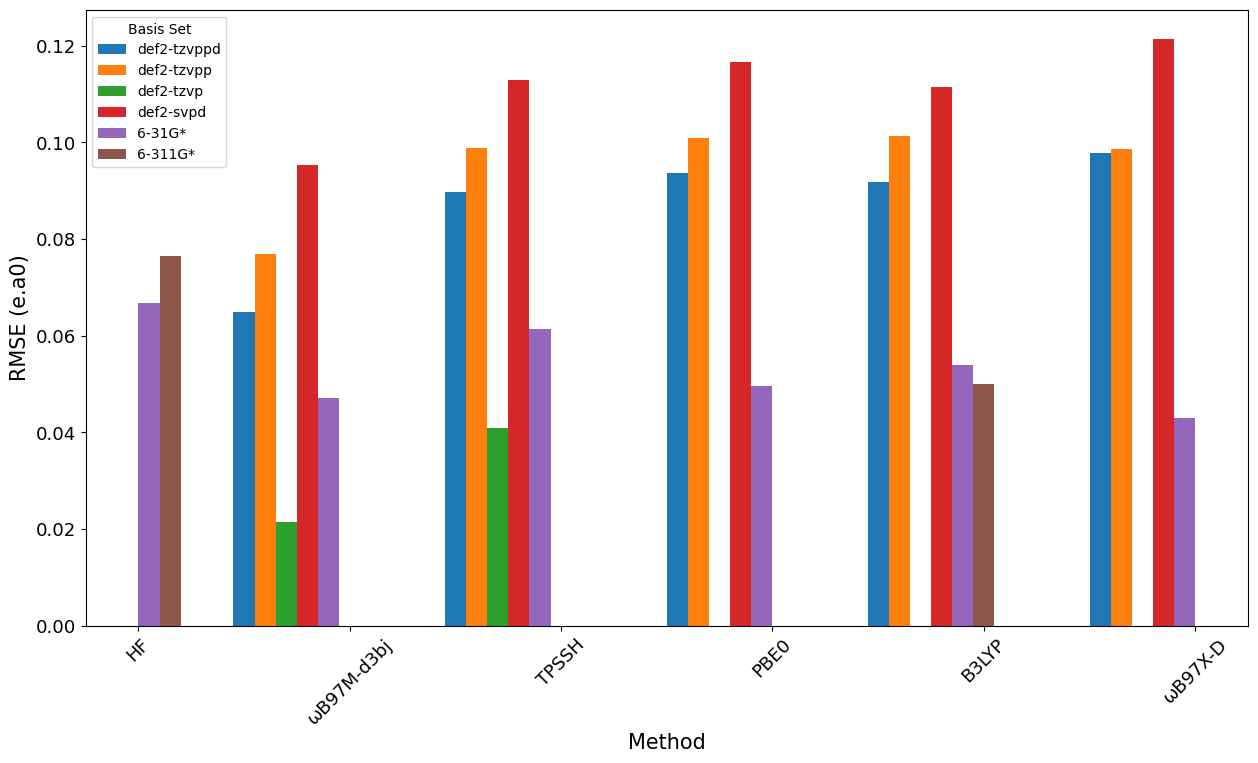

In [42]:
mpl.rcParams['font.size'] = 10          # Base font size
mpl.rcParams['axes.labelsize'] = 15     # Axis label font size
mpl.rcParams['legend.fontsize'] = 10
mpl.rcParams['xtick.labelsize'] =13
mpl.rcParams['ytick.labelsize'] = 13

# Create a DataFrame from the list
df_rmse = rmse_dipoles

# Extract method and basis from the 'spec' key
df_rmse['method'] = df_rmse['spec'].apply(lambda x: x.split('-')[0].upper())  # Convert method to uppercase for consistency
df_rmse['basis'] = df_rmse['spec'].apply(lambda x: '-'.join(x.split('-')[-2:]))

# Calculate average RMSE for each method to determine the order
average_rmse_by_method = df_rmse.groupby('method')['rmse'].mean().sort_values()

# Sort the dataframe by the average RMSE of each method
df_rmse['method_avg_rmse'] = df_rmse['method'].map(average_rmse_by_method)
df_rmse_sorted = df_rmse.sort_values(by=['method_avg_rmse', 'method', 'basis'])
df_rmse_sorted.drop('method_avg_rmse', axis=1, inplace=True)
# Use a categorical type to ensure the methods are plotted in the sorted order
df_rmse_sorted['method'] = pd.Categorical(df_rmse_sorted['method'], categories=average_rmse_by_method.index, ordered=True)

# Normalize basis set labels
df_rmse_sorted['basis'] = df_rmse_sorted['basis'].replace({
    'cc-pVTZ': 'cc-pvtz',
    'gas-tzvp': 'def2-tzvp',
    'gas-tzvppd': 'def2-tzvppd'
})

df_rmse_sorted['method'] = df_rmse_sorted['method'].replace({
    'WB97X': 'ωB97X-D',
    'WB97M': 'ωB97M-d3bj',
})

# Creating a color map
unique_basis = df_rmse_sorted['basis'].unique()
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_basis)))
color_map = dict(zip(unique_basis, colors))

desired_order = [
    'def2-tzvppd','def2-tzvpd','def2-tzvpp', 'def2-tzvp', 'def2-svpd',
    '6-31G*', '6-311G*'
]

df_rmse_sorted['basis'] = pd.Categorical(
    df_rmse_sorted['basis'],
    categories=desired_order,
    ordered=True
)


# Creating the pivot table
pivot_table = df_rmse_sorted.pivot_table(index='method', columns='basis', values='rmse', aggfunc = 'mean')
pivot_table_plot = pivot_table.drop(index='CCSD', errors='ignore')

fig, ax = plt.subplots(figsize=(15, 8))
bar_width = 0.1  # Adjust as necessary for the number of basis sets

# Determine the maximum number of non-NaN entries in a row (group)
group_width = np.max([np.sum(~pivot_table_plot.loc[method].isna()) 
                       for method in pivot_table_plot.index]) * bar_width

for i, basis in enumerate(pivot_table_plot.columns):
    # For each method (row) compute the offset for the current basis bar
    offsets = np.array([
        bar_width * (i - np.sum(~pivot_table_plot.loc[method].isna()) / 2)
        for method in pivot_table_plot.index
    ])
    positions = np.arange(len(pivot_table_plot.index)) + offsets
    ax.bar(positions, pivot_table_plot[basis], width=bar_width, label=basis)

# Set the x-axis ticks and labels based on the filtered methods
ax.set_xticks(np.arange(len(pivot_table_plot)) + bar_width / 2 * (len(pivot_table_plot.columns) - 1))
ax.set_xticklabels(pivot_table_plot.index, rotation=45)

ax.set_xlabel('Method')
ax.set_ylabel('RMSE (e.a0)')
ax.legend(title='Basis Set')
plt.savefig("Method_Basis_Dipoles.png",dpi=300,bbox_inches='tight')
plt.show()


In [43]:

df_rmse_sorted

,rmse,spec,method,basis
72,0.000000,ccsd-aug-cc-pVTZP,CCSD,NaN
13,0.076470,HF-gas-6-311G*,HF,6-311G*
12,0.066783,HF-6-31G*,HF,6-31G*
73,0.066783,HF-6-31G*,HF,6-31G*
52,0.047017,WB97M-D3BJ-gas-6-31G*,ωB97M-d3bj,6-31G*
...,...,...,...,...
62,0.151439,WB97X-D-ddx-78.4-def2-tzvpp,ωB97X-D,def2-tzvpp
69,0.018128,WB97X-D-gas-def2-tzvpp,ωB97X-D,def2-tzvpp
60,0.129317,WB97X-D-ddx-4-def2-tzvppd,ωB97X-D,def2-tzvppd
63,0.150476,WB97X-D-ddx-78.4-def2-tzvppd,ωB97X-D,def2-tzvppd


In [ ]:
df_prepared = df[['specification','molecule','basis','dipole','charges']]

pivot_df = df_prepared.pivot_table(index=['molecule'], 
                                   columns='specification', 
                                   values='charges',
                                   aggfunc=lambda x: x.iloc[0] if not x.empty else None).reset_index()

pivot_df
pivot_df.to_csv('charge_results.csv')

In [ ]:
pivot_df

specification,molecule,B3LYP-6-311G*-ddx-4 COSMO,B3LYP-6-31G*-ddx-4 COSMO,B3LYP-def2-svpd-ddx-4 COSMO,B3LYP-def2-tzvp-ddx-4 COSMO,B3LYP-def2-tzvpd-ddx-4 COSMO,B3LYP-def2-tzvpp-ddx-4 COSMO,B3LYP-def2-tzvppd-ddx-4 COSMO,HF-6-311G*-ddx-4 COSMO,HF-6-31G*-ddx-4 COSMO,...,WB97M-D3BJ-def2-tzvpp-ddx-4 COSMO,WB97M-D3BJ-def2-tzvppd-ddx-4 COSMO,WB97X-D-6-311G*-ddx-4 COSMO,WB97X-D-6-31G*-ddx-4 COSMO,WB97X-D-def2-svpd-ddx-4 COSMO,WB97X-D-def2-tzvp-ddx-4 COSMO,WB97X-D-def2-tzvpd-ddx-4 COSMO,WB97X-D-def2-tzvpp-ddx-4 COSMO,WB97X-D-def2-tzvppd-ddx-4 COSMO,ccsd-aug-cc-pVTZP
0,Brc1cc[nH]c1,"[-0.2718169739839899, -0.06638200574420736, -0...","[-0.2482689641540761, -0.034626250125769045, -...","[-0.24992836436246707, -0.03223570473243371, -...","[-0.26136243513826357, -0.060489552455425956, ...","[-0.2578522365806676, -0.057113602714217934, -...","[-0.25827809325913165, -0.056787114714757544, ...","[-0.2557683121122133, -0.05576020114655759, -0...","[-0.29280868788488296, -0.018471908992002607, ...","[-0.27782482476862236, 0.00331574554063152, -0...",...,"[-0.26887485728517757, -0.0532344370959924, -0...","[-0.2669213879316715, -0.05364807189170726, -0...","[-0.2815537973682308, -0.06571299079855751, -0...","[-0.2638008923230663, -0.041483777703687566, -...","[-0.26132066219431344, -0.032026061036999724, ...","[-0.26976011184827603, -0.057769614416716776, ...","[-0.2673324976431785, -0.055246939675787546, -...","[-0.2671358907326391, -0.05433421468582695, -0...","[-0.26537351293064254, -0.0541030341914177, -0...","[-0.2646661933457908, -0.049086306265596034, -..."
1,Brc1ccccc1,"[-0.14133832080761807, -0.12325871142526136, -...","[-0.12704985040538905, -0.11106605038094969, -...","[-0.12425994745758652, -0.10776474760087404, -...","[-0.13503707535023884, -0.11913962625509021, -...","[-0.13343465626300183, -0.11686532314252582, -...","[-0.13301112864852258, -0.11664526957273408, -...","[-0.13216093863171263, -0.11586417750566737, -...","[-0.1447943855662272, -0.12993539763109643, -0...","[-0.13493257685220886, -0.12186251166082177, -...",...,"[-0.13914253367611173, -0.12286203875434452, -...","[-0.13869439254664773, -0.1228705810014542, -0...","[-0.14892260292693155, -0.13082167620801308, -...","[-0.13884794264558634, -0.12268411516275078, -...","[-0.13315008963897979, -0.11682771992222521, -...","[-0.14201585213892762, -0.12607602599241804, -...","[-0.14122910854258122, -0.12485511837477163, -...","[-0.14036046547455888, -0.12398688877649092, -...","[-0.14013168691598743, -0.12402103847689007, -...",NaN
2,C1CCNC1,"[-0.2279938236009933, -0.22809390626310885, 0....","[-0.2129444395500667, -0.21302616185030585, 0....","[-0.2067937521928401, -0.20693149577116707, 0....","[-0.21636290254182164, -0.2164766987117448, 0....","[-0.21765815368061836, -0.21778031676147305, 0...","[-0.21435845314470744, -0.2144790566621501, 0....","[-0.21640130225011076, -0.21652989152119667, 0...","[-0.21185677229070005, -0.21194751007209334, 0...","[-0.20387090449803297, -0.20394493036572064, 0...",...,"[-0.2316225707415443, -0.23174161037979363, 0....","[-0.23516452569945723, -0.23530140679203895, 0...","[-0.24476403757928147, -0.24485724985400759, 0...","[-0.23508551825483642, -0.2351626001092943, 0....","[-0.22498251548329865, -0.22511385361923575, 0...","[-0.23501279186658414, -0.23512263074908324, 0...","[-0.23644534657992217, -0.23656524953274943, 0...","[-0.23303411345790528, -0.23314854841014213, 0...","[-0.23552205542611546, -0.23564824556948955, 0...","[-0.22799152875452647, -0.22812392019880687, 0..."
3,C1CCOC1,"[-0.2880734750415554, -0.2880917666758534, 0.1...","[-0.269985244661781, -0.26999769865655504, 0.1...","[-0.257831976327678, -0.25785262665368336, 0.1...","[-0.27201703522699194, -0.2720381481282204, 0....","[-0.2723241043398373, -0.27234325941147464, 0....","[-0.27127132244567376, -0.27129364558793057, 0...","[-0.27128934300392504, -0.2713094547416372, 0....","[-0.27494939943492386, -0.2749581695600586, 0....","[-0.2633086487464382, -0.2633130918413161, 0

In [ ]:

df_wall_time = df[['specification','molecule','basis','dipole','charges','wall time']]

pivot_df_wall_time = df_wall_time.pivot_table(index=['molecule'], 
                                   columns='specification', 
                                   values='wall time',
                                   aggfunc=lambda x: x.iloc[0] if not x.empty else None).reset_index()

pivot_df_wall_time


specification,molecule,B3LYP-6-311G*-ddx-4 COSMO,B3LYP-6-31G*-ddx-4 COSMO,B3LYP-def2-svpd-ddx-4 COSMO,B3LYP-def2-tzvp-ddx-4 COSMO,B3LYP-def2-tzvpd-ddx-4 COSMO,B3LYP-def2-tzvpp-ddx-4 COSMO,B3LYP-def2-tzvppd-ddx-4 COSMO,HF-6-311G*-ddx-4 COSMO,HF-6-31G*-ddx-4 COSMO,...,WB97M-D3BJ-def2-tzvpd-ddx-4 COSMO,WB97M-D3BJ-def2-tzvpp-ddx-4 COSMO,WB97M-D3BJ-def2-tzvppd-ddx-4 COSMO,WB97X-D-6-311G*-ddx-4 COSMO,WB97X-D-6-31G*-ddx-4 COSMO,WB97X-D-def2-svpd-ddx-4 COSMO,WB97X-D-def2-tzvp-ddx-4 COSMO,WB97X-D-def2-tzvpd-ddx-4 COSMO,WB97X-D-def2-tzvpp-ddx-4 COSMO,WB97X-D-def2-tzvppd-ddx-4 COSMO
0,Brc1cc[nH]c1,33.491380,35.020224,38.337425,41.459330,52.156195,41.187149,58.671229,31.085625,28.129402,...,100.598458,80.101196,83.122290,36.708118,39.354947,39.835359,45.057133,53.276009,40.499099,56.134256
1,Brc1ccccc1,38.784600,39.404968,45.363928,49.831823,85.269469,53.612614,69.930980,31.391948,30.995576,...,159.024256,129.989320,175.799496,42.795359,40.318588,48.773921,63.567480,67.553411,59.885317,110.508483
2,C1CCNC1,39.834290,34.546195,49.233741,50.536387,64.697090,76.742226,75.155489,28.065999,26.687054,...,126.272655,133.380229,173.486111,40.011517,31.807610,48.421123,54.102316,63.022741,59.066284,77.005259
3,C1CCOC1,35.237348,35.499802,41.888458,44.750413,61.202337,52.489557,66.145539,24.766154,24.315079,...,130.196391,103.680338,144.053299,34.511381,31.218368,40.581959,36.977845,57.509921,47.672004,52.941876
4,C1CC[NH2+]CC1,67.625262,59.399245,79.160110,85.853621,131.337379,105.074890,140.155100,49.469058,48.024020,...,267.103186,232.574543,258.181253,66.295916,53.839702,76.500194,84.540407,115.064560,114.974454,116.676224
5,CC,11.527979,10.351551,12.742241,14.250967,15.832614,16.102609,18.454492,8.252783,8.661585,...,23.868523,24.348580,25.328706,11.796396,10.405639,13.167694,13.726735,15.868922,15.454006,17.767082
6,CC(=O)O,15.655259,13.776054,18.408155,19.424185,23.674058,21.390956,24.290166,9.498492,10.069902,...,37.752533,33.605291,35.161519,15.476331,14.455518,16.626658,19.508387,22.811828,21.786593,25.129771
7,CC(=O)[O-],14.837050,12.529576,19.460326,22.220770,23.784956,20.159025,27.208471,10.036564,9.342908,...,35.790023,26.647385,39.718042,14.091165,12.950319,18.309515,18.831654,24.211622,20.384036,24.889661
8,CC(C)=O,23.910566,21.332624,27.625716,29.033240,34.543203,32.797194,40.536048,17.477951,16.435204,...,53.879991,50.844395,78.952847,24.001783,21.384178,27.919540,28.781015,34.674224,31.512166,38.608745
9,CC(C)F,28.649941,29.051744,36.133841,35.121608,41.640834,40.271046,46.761431,23.344873,19.723959,...,81.637891,83.130587,102.427056,28.574095,25.147321,33.479950,31.200769,41.781479,35.545960,42.652929


In [ ]:
pivot_df.to_csv('pivot_charges.csv')

In [ ]:
pivot_df['molecule'][0]

'Brc1cc[nH]c1'

In [ ]:
pivot_df.columns

Index(['molecule', 'B3LYP-6-311G*-ddx-4 COSMO', 'B3LYP-6-31G*-ddx-4 COSMO',
       'B3LYP-def2-svpd-ddx-4 COSMO', 'B3LYP-def2-tzvp-ddx-4 COSMO',
       'B3LYP-def2-tzvpd-ddx-4 COSMO', 'B3LYP-def2-tzvpp-ddx-4 COSMO',
       'B3LYP-def2-tzvppd-ddx-4 COSMO', 'HF-6-311G*-ddx-4 COSMO',
       'HF-6-31G*-ddx-4 COSMO', 'HF-def2-svpd-ddx-4 COSMO',
       'HF-def2-tzvp-ddx-4 COSMO', 'HF-def2-tzvpd-ddx-4 COSMO',
       'HF-def2-tzvpp-ddx-4 COSMO', 'HF-def2-tzvppd-ddx-4 COSMO',
       'PBE0-6-311G*-ddx-4 COSMO', 'PBE0-6-31G*-ddx-4 COSMO',
       'PBE0-def2-svpd-ddx-4 COSMO', 'PBE0-def2-tzvp-ddx-4 COSMO',
       'PBE0-def2-tzvpd-ddx-4 COSMO', 'PBE0-def2-tzvpp-ddx-4 COSMO',
       'PBE0-def2-tzvppd-ddx-4 COSMO', 'TPSSH-6-311G*-ddx-4 COSMO',
       'TPSSH-6-31G*-ddx-4 COSMO', 'TPSSH-def2-svpd-ddx-4 COSMO',
       'TPSSH-def2-tzvp-ddx-4 COSMO', 'TPSSH-def2-tzvpd-ddx-4 COSMO',
       'TPSSH-def2-tzvpp-ddx-4 COSMO', 'TPSSH-def2-tzvppd-ddx-4 COSMO',
       'WB97M-D3BJ-6-311G*-ddx-4 COSMO', 'WB97M-D3BJ-6

ccsd-gas-aug-cc-pvtz
dlpno-MP2-4-aug-cc-pvtz
dlpno-MP2-4-cc-pvtz
dlpno-MP2-78.4-aug-cc-pvtz
dlpno-MP2-78.4-cc-pvtz
dlpno-MP2-gas-aug-cc-pvtz
dlpno-MP2-gas-cc-pvtz
mp2-gas-6-311G*
MP2-4-aug-cc-pvtz
MP2-4-cc-pvtz
MP2-78.4-aug-cc-pvtz
MP2-78.4-cc-pvtz
MP2-gas-aug-cc-pvtz
MP2-gas-cc-pvtz
['B3LYP-6-311G*', 'B3LYP-6-31G*', 'B3LYP-def2-svpd', 'B3LYP-def2-tzvp', 'B3LYP-def2-tzvpd', 'B3LYP-def2-tzvpp', 'B3LYP-def2-tzvppd', 'HF-6-311G*', 'HF-6-31G*', 'HF-def2-svpd', 'HF-def2-tzvp', 'HF-def2-tzvpd', 'HF-def2-tzvpp', 'HF-def2-tzvppd', 'PBE0-6-311G*', 'PBE0-6-31G*', 'PBE0-def2-svpd', 'PBE0-def2-tzvp', 'PBE0-def2-tzvpd', 'PBE0-def2-tzvpp', 'PBE0-def2-tzvppd', 'TPSSH-6-311G*', 'TPSSH-6-31G*', 'TPSSH-def2-svpd', 'TPSSH-def2-tzvp', 'TPSSH-def2-tzvpd', 'TPSSH-def2-tzvpp', 'TPSSH-def2-tzvppd', 'WB97M-D3BJ-6-311G*', 'WB97M-D3BJ-6-31G*', 'WB97M-D3BJ-def2-svpd', 'WB97M-D3BJ-def2-tzvp', 'WB97M-D3BJ-def2-tzvpd', 'WB97M-D3BJ-def2-tzvpp', 'WB97M-D3BJ-def2-tzvppd', 'WB97X-D-6-311G*', 'WB97X-D-6-31G*', 'WB97X-D-d

/mnt/nfs/home/nca121/mambaforge/envs/openff_qc/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/nfs/home/nca121/mambaforge/envs/openff_qc/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


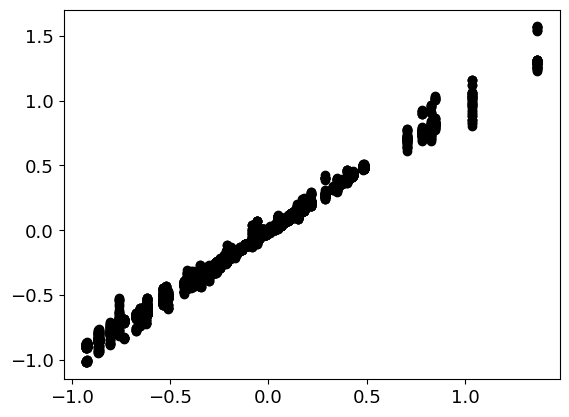

In [ ]:
from sklearn.metrics import mean_squared_error

#Step 0: fix column names
pivot_df.columns = [col.replace('-ddx-4 COSMO', '') if 'COSMO' in col else col for col in pivot_df.columns]
pivot_df_wall_time.columns = [col.replace('-ddx-4 COSMO', '') if 'COSMO' in col else col for col in pivot_df_wall_time.columns]
pivot_df = pivot_df[pivot_df.molecule != 'CC(=O)O']
pivot_df = pivot_df[pivot_df.molecule != 'B(O)(O)OCC']

# Step 1: Filter columns
# Exclude the first four columns and select only those with 'NoSolvent_nan' but not the target column itself
# columns_to_plot = [col for col in pivot_df.columns if 'gas' in col and col not in ['BaseExceptionGroupspecification','molecule','basis']]
columns_to_plot = list(pivot_df.columns)
columns_to_plot.remove('molecule')
columns_to_plot.append('HF-6-31G*')
remove_items = ['ccsd-gas-aug-cc-pvtz', 'dlpno-MP2-4-aug-cc-pvtz',
       'dlpno-MP2-4-cc-pvtz', 'dlpno-MP2-78.4-aug-cc-pvtz',
       'dlpno-MP2-78.4-cc-pvtz', 'dlpno-MP2-gas-aug-cc-pvtz',
       'dlpno-MP2-gas-cc-pvtz', 'mp2-gas-6-311G*','MP2-4-aug-cc-pvtz', 'MP2-4-cc-pvtz',
       'MP2-78.4-aug-cc-pvtz', 'MP2-78.4-cc-pvtz', 'MP2-gas-aug-cc-pvtz',
       'MP2-gas-cc-pvtz']

for item in remove_items:
    print(item)
    try:
        columns_to_plot.remove(item)
    except ValueError:
        continue

print(columns_to_plot)
# The target column for comparison
target_column = 'ccsd-aug-cc-pVTZP'

rmses = []
# df_rmse = pd.DataFrame(['spec','rmse'])
# Step 2: Plotting
# Loop through the selected columns and plot them against the target column
molecule_rmses = []
for col in columns_to_plot:
    clean_df = pivot_df[[target_column, col, 'molecule']].dropna()
    pivot_df_filter = pivot_df.filter(items = [target_column, col])
    pivot_df_wall_time_filter = pivot_df_wall_time.filter(items = [col])
    col_x = target_column
    x_tot = []
    y_tot = []
    w_time_tot = []
    for (index, row), (index_wt, row_wt) in zip(pivot_df_filter.iterrows(), pivot_df_wall_time_filter.iterrows()):
        x_values = row[col_x]
        if isinstance(x_values, np.ndarray):
                x_values = x_values.tolist()
                y_values = row[col]
                x_tot.extend(x_values)
                y_tot.extend(y_values)
                if 'ccsd' not in col:
                  w_time_tot.append(row_wt[col])
                # Check if y_values is a list and has the same length as x_values
                if isinstance(y_values, list) and len(x_values) == len(y_values):
                    plt.scatter(x_values, y_values, color='black')  # Use the color assigned to this column
                    rmse_molecule = np.sqrt(mean_squared_error(y_values, x_values))
                    information_molecule = {"molecule":clean_df['molecule'][index],
                                # "spec": spec,
                                "rmse": rmse_molecule
                                }
                    molecule_rmses.append(information_molecule)
    # print(len(x_tot))
    if len(x_tot) == 0:
         continue
    rmse = np.sqrt(mean_squared_error(x_tot, y_tot))
    wall_tm_mean = np.mean(w_time_tot)
    information = {"rmse": rmse,
                   "spec": col,
                   "wall time": wall_tm_mean}
    

    rmses.append(information)

    # plt.title(f'{col} vs. {target_column} (RMSE = {rmse:.2e} e)')        
    # plt.xlabel(target_column)
    # plt.ylabel(col)
    # # Plotting details
    # plt.grid(True)  # Optional: Add a grid for better readability
    # plt.show()
df_dft_rmse = pd.DataFrame(rmses)
df_molecules_rmse  = pd.DataFrame(molecule_rmses)



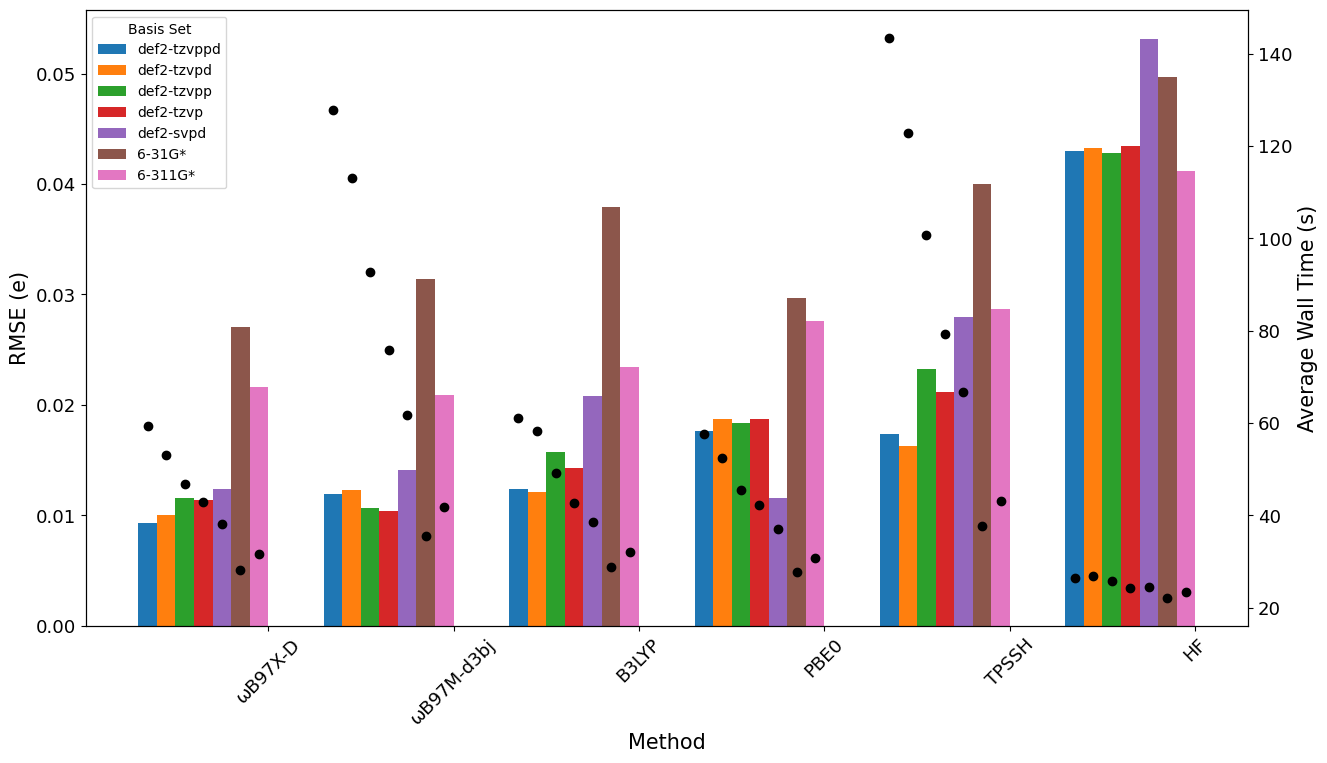

In [ ]:
mpl.rcParams['font.size'] = 10          # Base font size
mpl.rcParams['axes.labelsize'] = 15     # Axis label font size
mpl.rcParams['legend.fontsize'] = 10
mpl.rcParams['xtick.labelsize'] =13
mpl.rcParams['ytick.labelsize'] = 13


# Define your desired order for the basis sets
desired_order = [
    'def2-tzvppd','def2-tzvpd','def2-tzvpp', 'def2-tzvp', 'def2-svpd',
    '6-31G*', '6-311G*'
]

# Assume df_dft_rmse is your original DataFrame (make a copy for safety)
df_rmse = df_dft_rmse.copy()

# Extract 'method' and 'basis' from the 'spec' column
df_rmse['method'] = df_rmse['spec'].apply(lambda x: x.split('-')[0].upper())
df_rmse['basis'] = df_rmse['spec'].apply(lambda x: '-'.join(x.split('-')[-2:]))

# Optional: limit the DataFrame to only rows that have basis sets in your desired order
df_rmse = df_rmse[df_rmse['basis'].isin(desired_order)]

# Cast the 'basis' column as a categorical with your desired order
df_rmse['basis'] = pd.Categorical(df_rmse['basis'], categories=desired_order, ordered=True)

# (Keep the filter on RMSE as desired; note that in your sample, RMSE values are low so you might want "< 0.12")
df_rmse = df_rmse[df_rmse['rmse'] < 0.12]

# Calculate average RMSE by method to determine ordering of the methods
average_rmse_by_method = df_rmse.groupby('method')['rmse'].mean().sort_values()

# Sort the DataFrame by average RMSE, then method and basis
df_rmse['method_avg_rmse'] = df_rmse['method'].map(average_rmse_by_method)
df_rmse_sorted = df_rmse.sort_values(by=['method_avg_rmse', 'method', 'basis'])
df_rmse_sorted = df_rmse_sorted.drop(columns=['method_avg_rmse'])

# Ensure that the method column is a categorical with the proper ordering
df_rmse_sorted['method'] = pd.Categorical(
    df_rmse_sorted['method'],
    categories=average_rmse_by_method.index,
    ordered=True
)

df_rmse_sorted['method'] = df_rmse_sorted['method'].replace({
    'WB97X': 'ωB97X-D',
    'WB97M': 'ωB97M-d3bj',
})

# Create the pivot tables for RMSE and wall time
pivot_table = df_rmse_sorted.pivot_table(
    index='method',
    columns='basis',
    values='rmse',
    aggfunc='mean'
)
pivot_table_wall = df_rmse_sorted.pivot_table(
    index='method',
    columns='basis',
    values='wall time',
    aggfunc='mean'
)

# Remove the CCSD row from both pivot tables (if present)
pivot_table_plot = pivot_table.drop(index='CCSD', errors='ignore')
pivot_table_wall_plot = pivot_table_wall.drop(index='CCSD', errors='ignore')

# Drop any columns that are entirely NaN (e.g., those that might come only from CCSD)
pivot_table_plot = pivot_table_plot.dropna(axis=1, how='all')
pivot_table_wall_plot = pivot_table_wall_plot.dropna(axis=1, how='all')

# Re-index the pivot table columns to follow the desired order.
# (This will keep only those basis sets that are present in the data.)
pivot_table_plot = pivot_table_plot.reindex(columns=desired_order)
pivot_table_plot = pivot_table_plot.dropna(axis=1, how='all')
pivot_table_wall_plot = pivot_table_wall_plot.reindex(columns=desired_order)
pivot_table_wall_plot = pivot_table_wall_plot.dropna(axis=1, how='all')

# Use matplotlib's default color cycle
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
# Build a color mapping for each basis in the pivot table (based on the desired order)
color_map = {}
for basis in pivot_table_plot.columns:
    # Find the index in desired_order so that the color matches your specified order.
    idx = desired_order.index(basis)
    color_map[basis] = default_colors[idx % len(default_colors)]

# Now, create the plot with two y-axes (bars for RMSE and scatter for wall time)
fig, ax = plt.subplots(figsize=(15, 8))
ax2 = ax.twinx()
bar_width = 0.1

# (Optional) Calculate group width if you need it; here we compute the maximum number of non-NaN entries
counts = [np.sum(~pivot_table_plot.loc[method].isna()) for method in pivot_table_plot.index]
group_width = np.max(counts) * bar_width if counts else 0

# Loop over each basis (now in the desired order) to plot bars and scatter points
for i, basis in enumerate(pivot_table_plot.columns):
    # Compute an offset for each method based on how many basis values are present in that row
    offsets = np.array([
        bar_width * (i - np.sum(~pivot_table_plot.loc[method].isna()) / 2)
        for method in pivot_table_plot.index
    ])
    positions = np.arange(len(pivot_table_plot.index)) + offsets

    # Plot RMSE as bars using the default color assigned to this basis
    ax.bar(positions, pivot_table_plot[basis], width=bar_width, label=basis, color=color_map[basis])
    # Plot wall time as scatter points, using the same color
    ax2.scatter(positions, pivot_table_wall_plot[basis], label=basis, color='black')

# Set the x-axis tick positions and labels based on the method names
ax.set_xticks(np.arange(len(pivot_table_plot.index)) + bar_width / 2 * (len(pivot_table_plot.columns) - 1))
ax.set_xticklabels(pivot_table_plot.index, rotation=45)

# Label the axes and add a title and legend
ax.set_xlabel('Method')
ax.xaxis.set_label_coords(0,0.5)
ax.set_ylabel('RMSE (e)')
ax2.set_ylabel('Average Wall Time (s)')
ax.legend(title='Basis Set')
plt.savefig("Method_and_Basis_RMSE_PartialCharges.png",dpi=300,bbox_inches='tight')
plt.show()


In [28]:
df_prepared = df[['specification','molecule','basis','dipole','charges']]

pivot_df_dipole = df_prepared.pivot_table(index=['molecule'], 
                                   columns='specification', 
                                   values='dipole',
                                   aggfunc=lambda x: x.iloc[0] if not x.empty else None).reset_index()
pivot_df_dipole

specification,molecule,B3LYP-6-311G*-ddx-4 COSMO,B3LYP-6-31G*-ddx-4 COSMO,B3LYP-def2-svpd-ddx-4 COSMO,B3LYP-def2-tzvp-ddx-4 COSMO,B3LYP-def2-tzvpd-ddx-4 COSMO,B3LYP-def2-tzvpp-ddx-4 COSMO,B3LYP-def2-tzvppd-ddx-4 COSMO,HF-6-311G*-ddx-4 COSMO,HF-6-31G*-ddx-4 COSMO,...,WB97M-D3BJ-def2-tzvpp-ddx-4 COSMO,WB97M-D3BJ-def2-tzvppd-ddx-4 COSMO,WB97X-D-6-311G*-ddx-4 COSMO,WB97X-D-6-31G*-ddx-4 COSMO,WB97X-D-def2-svpd-ddx-4 COSMO,WB97X-D-def2-tzvp-ddx-4 COSMO,WB97X-D-def2-tzvpd-ddx-4 COSMO,WB97X-D-def2-tzvpp-ddx-4 COSMO,WB97X-D-def2-tzvppd-ddx-4 COSMO,ccsd-aug-cc-pVTZP
0,Brc1cc[nH]c1,"[-1.2953943231918856, -0.5252076718872747, -0....","[-1.3118822892410549, -0.5110151770381801, -0....","[-1.2603348337478621, -0.4971843054870426, -0....","[-1.2706383862526422, -0.5051492461239029, -0....","[-1.24649691118924, -0.4906426545635796, -0.13...","[-1.261662481162631, -0.5008752368520035, -0.1...","[-1.2461721466539757, -0.4900746361492061, -0....","[-1.3886944899277864, -0.5438494968748309, -0....","[-1.3983428621718588, -0.5243996013981249, -0....",...,"[-1.2739920154524498, -0.5108837101104502, -0....","[-1.260337842416618, -0.5004050087313505, -0.1...","[-1.313044223743077, -0.5348799317732471, -0.1...","[-1.325433384466919, -0.518971197646783, -0.14...","[-1.2913230936453601, -0.5080369146707948, -0....","[-1.296100343016576, -0.5171397170871401, -0.1...","[-1.271358677022647, -0.5038106483895959, -0.1...","[-1.2866187386722174, -0.5117436542837766, -0....","[-1.270006860333325, -0.5022571140716092, -0.1...","[-1.2333162800917705, -0.4930380861029402, -0...."
1,Brc1ccccc1,"[-0.7070148411128798, -0.037632012198887566, -...","[-0.7504798607498628, -0.03994425563852033, -0...","[-0.7019719494553271, -0.037361270264899105, -...","[-0.6987129182177512, -0.0371895897292962, -0....","[-0.6965723194471138, -0.037075359365035254, -...","[-0.6944060501369904, -0.03696026915674544, -0...","[-0.6968127625872853, -0.03708809158927373, -0...","[-0.8172765019907899, -0.04349179361430444, -0...","[-0.8596626760912045, -0.04574684031043752, -0...",...,"[-0.705223227594928, -0.03753125985587502, -0....","[-0.7090718255441857, -0.03773500922595119, -0...","[-0.7238867832255096, -0.038527590816094914, -...","[-0.7640135025320376, -0.04066250985915154, -0...","[-0.732919402610662, -0.0390041489275017, -0.0...","[-0.7204711400198107, -0.03834256835436811, -0...","[-0.7150087787327948, -0.03805095469581943, -0...","[-0.7173478152137136, -0.03817617527982087, -0...","[-0.7156239288629251, -0.0380836004278482, -0....",NaN
2,C1CCNC1,"[-0.05340733622930216, 0.07182754499833566, 0....","[-0.040306160275938474, 0.05983945598220153, 0...","[-0.03508005739546949, 0.056428395755045546, 0...","[-0.03906031082588246, 0.058699069660290704, 0...","[-0.03219053856960663, 0.05356931587712177, 0....","[-0.03849316642676026, 0.057787212422743206, 0...","[-0.032267689292735824, 0.05361065450987068, 0...","[-0.03622914786590847, 0.060269069645700224, 0...","[-0.023416313261286348, 0.04944599764160662, 0...",...,"[-0.03768384362811794, 0.05807079435683127, 0....","[-0.03208273488453983, 0.05450675795946358, 0....","[-0.04850822903431773, 0.06908904968048724, 0....","[-0.034715001411026236, 0.05666578367788455, 0...","[-0.03050763573996562, 0.053861670084889735, 0...","[-0.03754108083918162, 0.05882203199288005, 0....","[-0.03208415238814499, 0.0547786966800925, 0.3...","[-0.0355803450061245, 0.05665928398685738, 0.3...","[-0.031276171104672734, 0.05406370288403339, 0...","[-0.026712145542145294, 0.05056951378575869, 0..."
3,C1CCOC1,"[-0.5432887901474004, 0.3476876857324278, -0.1...","[-0.5354847203230602, 0.3426869544644493, -0.1...","[-0.5656917949597151, 0.36203375817628647, -0....","[-0.5413539051448968, 0.3464536559728657, -0.1...","[-0.5470675531582252, 0.35011504926654524, -0....","[-0.5378627330490886, 0.34422068017565977, -0....","[-0.5468231945293454, 0.3499589508983316, -0.1...","[-0.6050645442135583, 0.38722348449260124, -0....","[-0.6089516191497442, 0.38970623134099647, -

In [29]:
df_rmse

,rmse,spec,wall time,method,basis,method_avg_rmse
0,0.023397,B3LYP-6-311G*,32.142591,B3LYP,6-311G*,0.019511
1,0.037915,B3LYP-6-31G*,28.789605,B3LYP,6-31G*,0.019511
2,0.020785,B3LYP-def2-svpd,38.551195,B3LYP,def2-svpd,0.019511
3,0.014259,B3LYP-def2-tzvp,42.621951,B3LYP,def2-tzvp,0.019511
4,0.012120,B3LYP-def2-tzvpd,58.276651,B3LYP,def2-tzvpd,0.019511
5,0.015709,B3LYP-def2-tzvpp,49.220770,B3LYP,def2-tzvpp,0.019511
6,0.012390,B3LYP-def2-tzvppd,61.127872,B3LYP,def2-tzvppd,0.019511
7,0.041220,HF-6-311G*,23.405934,HF,6-311G*,0.045781
8,0.049731,HF-6-31G*,22.206347,HF,6-31G*,0.045781
9,0.053136,HF-def2-svpd,24.399962,HF,def2-svpd,0.045781


In [30]:
pivot_df_dipole['molecule'].unique()

array(['Brc1cc[nH]c1', 'Brc1ccccc1', 'C1CCNC1', 'C1CCOC1',
       'C1CC[NH2+]CC1', 'CC', 'CC(=O)O', 'CC(=O)[O-]', 'CC(C)=O',
       'CC(C)F', 'CCO', 'CCOB(O)O', 'CCS', 'CCSC', 'COC', 'COCC(F)(F)F',
       'COC[B-](F)(F)F', 'CO[Si](C)(C)O', 'CS(=O)(=O)[O-]',
       'C[Si]1(C)CCCC1', 'Cc1c[nH]c2ccccc12', 'Clc1ccccc1', 'Clc1cccnc1',
       'Fc1cccc(F)c1F', 'Fc1ccccc1', 'N#Cc1ccccc1', 'Nc1ccccc1',
       'O=C1CCCN1', 'Oc1ccccc1', '[O-]c1ccsn1', '[S-]c1ccccc1',
       'c1c[nH+]c[nH]1', 'c1ccccc1', 'c1ccsc1'], dtype=object)

In [ ]:
esp_db =MoleculePropStore('./benchmark_NEW.db')
smiles_list = pivot_df_dipole['molecule'].unique()
df_rmse
# Some methods won't be indexed if we don't change them
df_rmse['method'] = df_rmse['method'].replace({
    'WB97M': 'ωB97X-D',
    'WB97X': 'ωB97M-d3bj'
})

add_data = []
for mol in smiles_list:
    for row in df_rmse[['method','basis']].iterrows():
        method = row[1]['method']
        basis = row[1]['basis']
        try:
            item =  esp_db.retrieve(smiles=mol,method=method.lower(),basis=basis.lower(), implicit_solvent=None)
            record_data = {
                    "specification": f'gas-{method}-{basis}',
                    "molecule": mol,
                    "basis":basis ,
                    "conformer_geom": item[0].conformer,
                    "dipole": item[0].dipole,
                    "charges": item[0].mbis_charges.flatten(),
                    "mbis dipoles": item[0].mbis_dipole.flatten(),
                    "mbis quadrupoles": item[0].mbis_quadropole.flatten(),
                    "esp": item[0].esp_quantity,
                    "grid": item[0].grid_coordinates_quantity,
                }
            add_data.append(record_data)
        except IndexError:
            continue
df_esps = pd.DataFrame(add_data)

df_esp_all = pd.concat([df_esps,df_ccsd], axis=0)
df_esp_all

,specification,molecule,tagged_smiles,basis,conformer_geom,dipole,charges,mbis dipoles,mbis quadrupoles,esp,grid
0,ccsd-aug-cc-pVTZP,Brc1cc[nH]c1,[C:1]1([H:7])=[C:2]([H:8])[N:3]([H:9])[C:4]([H...,aug-cc-pVTZP,"[[0.1788152130500086, 1.151987797806748, 0.292...","[-1.2333162800917705, -0.4930380861029402, -0....","[-0.2646661933457908, -0.049086306265596034, -...","[0.047299645273462615, -0.0007126072069741501,...","[-4.8833906424089255, 0.015769595358210774, -0...","[[0.022713849 hartree / elementary_charge], [0...","[[-4.24264068711929 angstrom, -0.3535533900640..."
1,ccsd-aug-cc-pVTZP,C1CCNC1,[C:1]1([H:6])([H:7])[C:2]([H:8])([H:9])[C:3]([...,aug-cc-pVTZP,"[[0.17920492040987654, -1.2075743017523377, -0...","[-0.026712145542145294, 0.05056951378575869, 0...","[-0.22799152875452647, -0.22812392019880687, 0...","[0.013743735116194093, 0.07779055321285057, -0...","[-4.765548910423305, -0.007358417402711934, 0....","[[0.0017020617 hartree / elementary_charge], [...","[[-4.242640687497272 angstrom, -1.767766952588..."
2,ccsd-aug-cc-pVTZP,c1c[nH+]c[nH]1,[C:1]1([H:6])=[C:2]([H:7])[N+:3]([H:8])=[C:4](...,aug-cc-pVTZP,"[[0.322131389189201, 1.1258221833999076, 0.208...","[-0.45465621640892806, -0.37258948817769433, 0...","[-0.013310363879025676, -0.013325506226216999,...","[-0.11370138463905655, -0.005826075836657907, ...","[-4.237902552945029, 0.04957317972600007, -0.0...","[[0.1350115498 hartree / elementary_charge], [...","[[-4.242640687648462 angstrom, -1.060660171779..."
3,ccsd-aug-cc-pVTZP,CC,[C:1]([C:2]([H:6])([H:7])[H:8])([H:3])([H:4])[...,aug-cc-pVTZP,"[[-0.7612104398492797, 0.017044349125372865, 0...","[-5.879472021186327e-07, 5.4610909655224485e-0...","[-0.3469240686738951, -0.3469255377463547, 0.1...","[0.0984460290692684, -0.0022159810034493074, -...","[-5.038637037567659, 0.0028044722941003857, 0....","[[-0.0013929407 hartree / elementary_charge], ...","[[-3.889087296526004 angstrom, -1.060660171118..."
4,ccsd-aug-cc-pVTZP,CC(C)F,[C:1]([C:2]([C:3]([H:9])([H:10])[H:11])([F:4])...,aug-cc-pVTZP,"[[1.29158718700037, -0.06744423805517061, 0.06...","[0.06456014464451565, -0.7196493711461187, -0....","[-0.5383107562171786, 0.3480754379878498, -0.5...","[-0.02311459292866743, 0.0042781688174169255, ...","[-5.326063113961956, 0.024730363430718327, -0....","[[0.0030003664 hartree / elementary_charge], [...","[[-4.596194077231488 angstrom, -0.707106781667..."
5,ccsd-aug-cc-pVTZP,CC(C)=O,[C:1]([C:2](=[O:3])[C:4]([H:8])([H:9])[H:10])(...,aug-cc-pVTZP,"[[-1.2682093729697623, -0.032316514147787745, ...","[0.010470037688955436, -0.9534418378565128, 0....","[-0.6154394709911084, 0.7044189377684932, -0.5...","[-0.01067522126368746, 0.0028125963504545223, ...","[-5.420680005478852, -0.010118930081316143, 0....","[[0.0046395656 hartree / elementary_charge], [...","[[-4.596194077712559 angstrom, -0.353553391122..."
6,ccsd-aug-cc-pVTZP,CCO,[C:1]([C:2]([O:3][H:9])([H:7])[H:8])([H:4])([H...,aug-cc-pVTZP,"[[0.9196771974059369, -0.0491799083690904, 0.0...","[0.3893203584998144, -0.07508604650575013, -0....","[-0.5213364136240399, 0.17863501334120857, -0....","[-0.028840943463215182, -0.00551224107322009, ...","[-5.3583640415035605, -0.01989580970363906, -0...","[[-0.015205761 hartree / elementary_charge], [...","[[-4.242640687119285 angstrom, 5.8796880944258..."
7,ccsd-aug-cc-pVTZP,CCOB(O)O,[B:1]([O:2][H:7])([O:3][H:8])[O:4][C:5]([C:6](...,aug-cc-pVTZP,"[[1.5755554013489759, 0.03368883995156969, 0.1...","[-1.248683556457145, -0.1724645798406581, 0.18...","[1.3655534063080679, -0.9265124259478049, -0.9...","[0.03416239878486405, 0.0197003100472325, -0.0...","[-2.0717858800385596, 0.04753121976409949, 0.0...","[[0.0106525357 hartree / elementary_charge], [...","[[-4.949747468305827 angstrom, -4.070594032785..."
8,ccsd-aug-cc-pVTZP,CC(=O)[O-],[C:1]([C:2](=[O:3])[O-:4])([H:5])([H:6])[H:7],aug-cc-pVTZP,"[[-0.6526727017826608, -0.01751515832894348, -...","[-2.6966309375719746, -0.036793406640808546, -...","[-0.7571350273229245, 1.0341670159072085, -0.8...

In [35]:
df_prepared_esp = df_esp_all[['specification','molecule','basis','dipole','charges','esp']]

pivot_df_esp = df_prepared_esp.pivot_table(index=['molecule'], 
                                   columns='specification', 
                                   values='esp',
                                   aggfunc=lambda x: x.iloc[0] if not x.empty else None).reset_index()
pivot_df_esp

specification,molecule,ccsd-aug-cc-pVTZP,gas-B3LYP-6-311G*,gas-B3LYP-6-31G*,gas-B3LYP-def2-svpd,gas-B3LYP-def2-tzvp,gas-B3LYP-def2-tzvpd,gas-B3LYP-def2-tzvpp,gas-B3LYP-def2-tzvppd,gas-HF-6-311G*,...,gas-wb97m-d3bj-def2-tzvpd,gas-wb97m-d3bj-def2-tzvpp,gas-wb97m-d3bj-def2-tzvppd,gas-wb97x-d-6-311G*,gas-wb97x-d-6-31G*,gas-wb97x-d-def2-svpd,gas-wb97x-d-def2-tzvp,gas-wb97x-d-def2-tzvpd,gas-wb97x-d-def2-tzvpp,gas-wb97x-d-def2-tzvppd
0,Brc1cc[nH]c1,"[[0.022713849 hartree / elementary_charge], [0...",[0.023377867879353587 hartree / elementary_cha...,[0.02285397659207774 hartree / elementary_char...,[0.021843365447253522 hartree / elementary_cha...,[0.022419127222493236 hartree / elementary_cha...,[0.02172623772435606 hartree / elementary_char...,[0.022168147783048195 hartree / elementary_cha...,[0.021699951052711264 hartree / elementary_cha...,[0.02468823509736292 hartree / elementary_char...,...,[0.022106443155695824 hartree / elementary_cha...,[0.022509593970451443 hartree / elementary_cha...,[0.022075712030866116 hartree / elementary_cha...,[0.02387250776369993 hartree / elementary_char...,[0.023387076665746027 hartree / elementary_cha...,[0.022585102834306897 hartree / elementary_cha...,[0.0229466194894194 hartree / elementary_charg...,[0.02233078640686814 hartree / elementary_char...,[0.02267573956976622 hartree / elementary_char...,[0.022279843378777683 hartree / elementary_cha...
1,Brc1ccccc1,NaN,[0.01068552749268464 hartree / elementary_char...,[0.010376226000822305 hartree / elementary_cha...,[0.010018860601756108 hartree / elementary_cha...,[0.010260834689116956 hartree / elementary_cha...,[0.010057763117886748 hartree / elementary_cha...,[0.01012569520089661 hartree / elementary_char...,[0.010037123355099249 hartree / elementary_cha...,[0.01218901421081234 hartree / elementary_char...,...,[0.010393821968790408 hartree / elementary_cha...,[0.010455075149355059 hartree / elementary_cha...,[0.010401296357193935 hartree / elementary_cha...,[0.011246718240047159 hartree / elementary_cha...,[0.01107018734951477 hartree / elementary_char...,[0.010802475991447544 hartree / elementary_cha...,[0.01078691200562262 hartree / elementary_char...,[0.010631689471688794 hartree / elementary_cha...,[0.010676231006677838 hartree / elementary_cha...,[0.01061801898355542 hartree / elementary_char...
2,C1CCNC1,"[[0.0017020617 hartree / elementary_charge], [...",[0.0019819246524756563 hartree / elementary_ch...,[0.0017442097728366552 hartree / elementary_ch...,[0.001811383872614114 hartree / elementary_cha...,[0.0017900708131253474 hartree / elementary_ch...,[0.0018823085310684436 hartree / elementary_ch...,[0.0018059404846084794 hartree / elementary_ch...,[0.0018854742879219303 hartree / elementary_ch...,[0.001995042835740619 hartree / elementary_cha...,...,[0.0019727561762765615 hartree / elementary_ch...,[0.0019021319824142123 hartree / elementary_ch...,[0.0019716282166622255 hartree / elementary_ch...,[0.0021657034575920282 hartree / elementary_ch...,[0.0020063255452581865 hartree / elementary_ch...,[0.0020036215245654502 hartree / elementary_ch...,[0.00196933298471663 hartree / elementary_char...,[0.0020378828401142234 hartree / elementary_ch...,[0.0019792387525705154 hartree / elementary_ch...,[0.002038699250617114 hartree / elementary_cha...
3,C1CCOC1,NaN,[0.006890883378544282 hartree / elementary_cha...,[0.00680060510887148 hartree / elementary_char...,[0.007038766475974281 hartree / elementary_cha...,[0.006855069767806485 hartree / elementary_cha...,[0.006908800575370634 hartree / elementary_cha...,[0.006836287166915706 hartree / elementary_cha...,[0.006897652198100617 hartree / elementary_cha...,[0.007520706997190622 hartree / elementary_cha...,...,[0.007062080670273079 hartree / elementary_cha...,[0.0069937705172066055 hartree / elementary_ch...,[0.007051821545240287 hartree / elementary_cha...,[0.007207176656837156 hartree / elementary_cha...,[0.007225367297173686 hartree / elementary_cha...,[0.007295285798980067 hartree / elementary_

In [133]:
from openff.units import unit

HA_TO_KCAL_P_MOL = 627.509391  # Hartrees to kilocalories per mole

columns_to_plot = [col for col in pivot_df_esp.columns if 'gas' in col and col not in ['BaseExceptionGroupspecification','molecule','basis']]
print(columns_to_plot)

for item in remove_items:
    try:
        columns_to_plot.remove(item)
    except ValueError:
        continue

target_column = 'ccsd-aug-cc-pVTZP'

rmses = []
pivot_df_esp['molecule']
molecule_rmses = []
for col in columns_to_plot:
    clean_df = pivot_df_esp[[target_column, col, 'molecule']].dropna()
    pivot_df_filter = pivot_df_esp.filter(items = [target_column, col, 'molecule'])
    pivot_df_wall_time_filter = pivot_df_wall_time.filter(items = [col])
    col_x = target_column
    x_tot = []
    y_tot = []
    w_time_tot = []
    for (index, row), (index_wt, row_wt) in zip(pivot_df_filter.iterrows(), pivot_df_wall_time_filter.iterrows()):
        x_values = row[col_x]
        if isinstance(x_values, unit.Quantity):
                x_values = x_values.m.flatten().tolist()
                y_values = row[col].m.flatten().tolist()
                rmse = np.sqrt(mean_squared_error(x_values, y_values))*HA_TO_KCAL_P_MOL
                # if rmse > 1:
                #     print(f"rmse of {row['molecule']} for method {col}")
                #     print(rmse)
                if len(x_values) != len(y_values):
                    print(f"excluding {row['molecule']} due mismatch len")
                    print(col)
                    continue
                # if "-" in row['molecule']:
                x_tot.extend(x_values)
                y_tot.extend(y_values)
    if len(x_tot) == 0:
         continue
    rmse = np.sqrt(mean_squared_error(x_tot, y_tot))*HA_TO_KCAL_P_MOL
    wall_tm_mean = np.mean(w_time_tot)
    information = {"rmse": rmse,
                   "spec": col,
                   "wall time": wall_tm_mean}
    

    rmses.append(information)

df_dft_rmse_esp = pd.DataFrame(rmses)
df_dft_rmse_esp

['gas-B3LYP-6-311G*', 'gas-B3LYP-6-31G*', 'gas-B3LYP-def2-svpd', 'gas-B3LYP-def2-tzvp', 'gas-B3LYP-def2-tzvpd', 'gas-B3LYP-def2-tzvpp', 'gas-B3LYP-def2-tzvppd', 'gas-HF-6-311G*', 'gas-HF-6-31G*', 'gas-HF-def2-svpd', 'gas-HF-def2-tzvp', 'gas-HF-def2-tzvpd', 'gas-HF-def2-tzvpp', 'gas-HF-def2-tzvppd', 'gas-PBE0-6-311G*', 'gas-PBE0-6-31G*', 'gas-PBE0-def2-svpd', 'gas-PBE0-def2-tzvp', 'gas-PBE0-def2-tzvpd', 'gas-PBE0-def2-tzvpp', 'gas-PBE0-def2-tzvppd', 'gas-TPSSH-6-311G*', 'gas-TPSSH-6-31G*', 'gas-TPSSH-def2-svpd', 'gas-TPSSH-def2-tzvp', 'gas-TPSSH-def2-tzvpd', 'gas-TPSSH-def2-tzvpp', 'gas-TPSSH-def2-tzvppd', 'gas-wb97m-d3bj-6-311G*', 'gas-wb97m-d3bj-6-31G*', 'gas-wb97m-d3bj-def2-svpd', 'gas-wb97m-d3bj-def2-tzvp', 'gas-wb97m-d3bj-def2-tzvpd', 'gas-wb97m-d3bj-def2-tzvpp', 'gas-wb97m-d3bj-def2-tzvppd', 'gas-wb97x-d-6-311G*', 'gas-wb97x-d-6-31G*', 'gas-wb97x-d-def2-svpd', 'gas-wb97x-d-def2-tzvp', 'gas-wb97x-d-def2-tzvpd', 'gas-wb97x-d-def2-tzvpp', 'gas-wb97x-d-def2-tzvppd']


/mnt/nfs/home/nca121/mambaforge/envs/openff_qc/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/nfs/home/nca121/mambaforge/envs/openff_qc/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/mnt/nfs/home/nca121/mambaforge/envs/openff_qc/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/nfs/home/nca121/mambaforge/envs/openff_qc/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/mnt/nfs/home/nca121/mambaforge/envs/openff_qc/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/nfs/hom

/mnt/nfs/home/nca121/mambaforge/envs/openff_qc/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/nfs/home/nca121/mambaforge/envs/openff_qc/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/mnt/nfs/home/nca121/mambaforge/envs/openff_qc/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/nfs/home/nca121/mambaforge/envs/openff_qc/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/mnt/nfs/home/nca121/mambaforge/envs/openff_qc/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/nfs/hom

,rmse,spec,wall time
0,0.995042,gas-B3LYP-6-311G*,NaN
1,1.003215,gas-B3LYP-6-31G*,NaN
2,0.641635,gas-B3LYP-def2-svpd,NaN
3,0.714992,gas-B3LYP-def2-tzvp,NaN
4,0.644124,gas-B3LYP-def2-tzvpd,NaN
5,0.715396,gas-B3LYP-def2-tzvpp,NaN
6,0.643302,gas-B3LYP-def2-tzvppd,NaN
7,1.215906,gas-HF-6-311G*,NaN
8,1.088109,gas-HF-6-31G*,NaN
9,1.096513,gas-HF-def2-svpd,NaN


In [136]:
df_dft_rmse_esp.sort_values(by='rmse')

,rmse,spec,wall time,method,basis
2,0.641635,gas-B3LYP-def2-svpd,NaN,B3LYP,def2-svpd
6,0.643302,gas-B3LYP-def2-tzvppd,NaN,B3LYP,def2-tzvppd
4,0.644124,gas-B3LYP-def2-tzvpd,NaN,B3LYP,def2-tzvpd
34,0.648134,gas-wb97m-d3bj-def2-tzvppd,NaN,wb97m-d3bj,def2-tzvppd
32,0.652219,gas-wb97m-d3bj-def2-tzvpd,NaN,wb97m-d3bj,def2-tzvpd
30,0.669397,gas-wb97m-d3bj-def2-svpd,NaN,wb97m-d3bj,def2-svpd
41,0.681405,gas-wb97x-d-def2-tzvppd,NaN,wb97x-d,def2-tzvppd
39,0.687057,gas-wb97x-d-def2-tzvpd,NaN,wb97x-d,def2-tzvpd
23,0.693143,gas-TPSSH-def2-svpd,NaN,TPSSH,def2-svpd
16,0.699971,gas-PBE0-def2-svpd,NaN,PBE0,def2-svpd


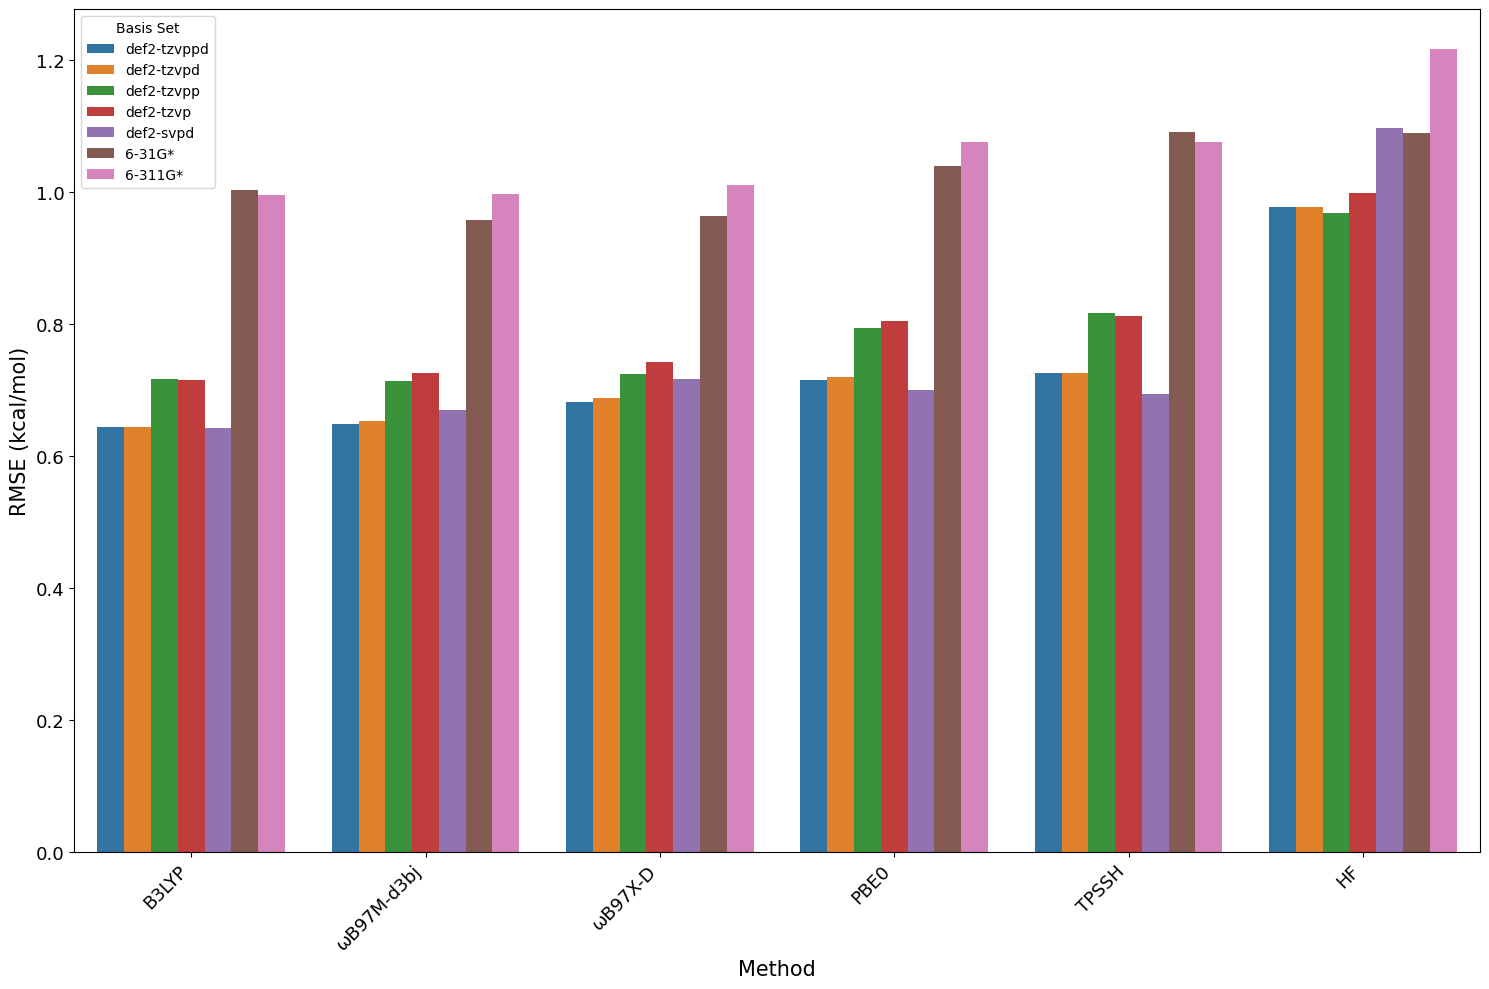

In [139]:

mpl.rcParams['font.size'] = 10          # Base font size
mpl.rcParams['axes.labelsize'] = 15     # Axis label font size
mpl.rcParams['legend.fontsize'] = 10
mpl.rcParams['xtick.labelsize'] =13
mpl.rcParams['ytick.labelsize'] = 13


df = df_dft_rmse_esp

# 2) Parse out the method and basis
def parse_spec(spec):
    known_bases = {'def2-tzvppd','def2-tzvpd','def2-tzvpp', 'def2-tzvp', 'def2-svpd',
    '6-31G*', '6-311G*'}
    # Remove "gas-" from the beginning
    spec_core = spec[4:]
    parts = spec_core.split('-')
    
    # Identify the basis from the end
    for i in range(1, 3):  
        # Join the last i elements
        possible_basis = '-'.join(parts[-i:])
        if possible_basis in known_bases:
            basis = possible_basis
            # The method is everything else
            method = '-'.join(parts[:-i])
            return method, basis
    return None, None

df["method"], df["basis"] = zip(*df["spec"].apply(parse_spec))


df['method'] = df['method'].replace({
    'wb97x-d': 'ωB97X-D',
    'wb97m-d3bj': 'ωB97M-d3bj'
})

# Compute the average RMSE for each method and sort from lowest to highest RMSE
average_rmse = df.groupby('method')['rmse'].mean().sort_values()

# Create the new method order list: most accurate (lowest rmse) on the left to least accurate on the right
method_order_sorted = average_rmse.index.tolist()

basis_order = [
    'def2-tzvppd','def2-tzvpd','def2-tzvpp', 'def2-tzvp', 'def2-svpd',
    '6-31G*', '6-311G*'
]
plt.figure(figsize=(15, 10))
sns.barplot(
    data=df, 
    x="method", 
    y="rmse", 
    hue="basis",
    order=method_order_sorted, 
    hue_order=basis_order
)
# plt.title("RMSE by Method and Basis Set")
plt.xticks(rotation=45, ha="right")
plt.ylabel("RMSE (kcal/mol)")
plt.xlabel("Method")
plt.legend(title="Basis Set")
plt.tight_layout()
plt.savefig('Method_and_Basis_ESP.png',dpi=300)
plt.show()
